In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt

from ResNet.ResNet import ResNet
from medmnist import PathMNIST, Evaluator

In [2]:
# Load data
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

#Load data
train_dataset = PathMNIST(split='train', transform=data_transform, download=True, size=224, mmap_mode='r')
val_dataset = PathMNIST(split='val', transform=data_transform, download=True, size=224, mmap_mode='r')
train_loader = data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)


num_classes = 9
#Alternatively load random
# train_data = torch.randn(1000, 3, 224, 224)  # 1000 random images
# train_labels = torch.randint(0, num_classes, (1000,))  # 1000 random labels
# train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

print(train_dataset[0][0].shape, train_dataset[0][1].shape)

Using downloaded and verified file: C:\Users\marga\.medmnist\pathmnist_224.npz
Using downloaded and verified file: C:\Users\marga\.medmnist\pathmnist_224.npz
torch.Size([3, 224, 224]) (1,)


In [12]:
#Load model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using: {device}')

models_folder = "models"
model_name = "ResNet3463"

model_folder = os.path.join(models_folder, model_name)
if not os.path.exists(model_folder):
    os.makedirs(model_folder)
    print(f"Created folder: {model_folder}")
else:
    print(f"Folder already exists: {model_folder}")

model = ResNet([3, 4, 6, 3], num_classes)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 50

Using: cuda
Folder already exists: models\ResNet3463


Epoch 1 of 50


Epoch 1: Train Loss = 0.4007, Train Acc = 85.94%, Val Loss = 0.2583, Val Acc = 91.36%
Epoch 2 of 50


Epoch 2: Train Loss = 0.1348, Train Acc = 95.49%, Val Loss = 0.1062, Val Acc = 96.29%
Epoch 3 of 50


Epoch 3: Train Loss = 0.0875, Train Acc = 97.11%, Val Loss = 0.0851, Val Acc = 97.20%
Epoch 4 of 50


Epoch 4: Train Loss = 0.0622, Train Acc = 97.95%, Val Loss = 0.0791, Val Acc = 97.52%
Epoch 5 of 50


Epoch 5: Train Loss = 0.0516, Train Acc = 98.25%, Val Loss = 0.0609, Val Acc = 98.04%
Epoch 6 of 50


Epoch 6: Train Loss = 0.0424, Train Acc = 98.58%, Val Loss = 0.0759, Val Acc = 97.47%
Epoch 7 of 50


Epoch 7: Train Loss = 0.0369, Train Acc = 98.77%, Val Loss = 0.0594, Val Acc = 98.29%
Epoch 8 of 50


Epoch 8: Train Loss = 0.0290, Train Acc = 99.04%, Val Loss = 0.0666, Val Acc = 97.82%
Epoch 9 of 50


Epoch 9: Train Loss = 0.0242, Train Acc = 99.20%, Val Loss = 0.0321, Val Acc = 99.05%
Epoch 10 of 50


Epoch 10: Train Loss = 0.0191, Train Acc = 99.34%, Val Loss = 0.0303, Val Acc = 99.10%
Epoch 11 of 50


Epoch 11: Train Loss = 0.0139, Train Acc = 99.56%, Val Loss = 0.0612, Val Acc = 98.32%
Epoch 12 of 50


Epoch 12: Train Loss = 0.0124, Train Acc = 99.60%, Val Loss = 0.0421, Val Acc = 98.74%
Epoch 13 of 50


Epoch 13: Train Loss = 0.0127, Train Acc = 99.57%, Val Loss = 0.0258, Val Acc = 99.19%
Epoch 14 of 50


Epoch 14: Train Loss = 0.0129, Train Acc = 99.57%, Val Loss = 0.0427, Val Acc = 98.88%
Epoch 15 of 50


Epoch 15: Train Loss = 0.0091, Train Acc = 99.71%, Val Loss = 0.0260, Val Acc = 99.32%
Epoch 16 of 50


Epoch 16: Train Loss = 0.0083, Train Acc = 99.75%, Val Loss = 0.0286, Val Acc = 99.14%
Early stopping triggered after epoch 16
Training finished.


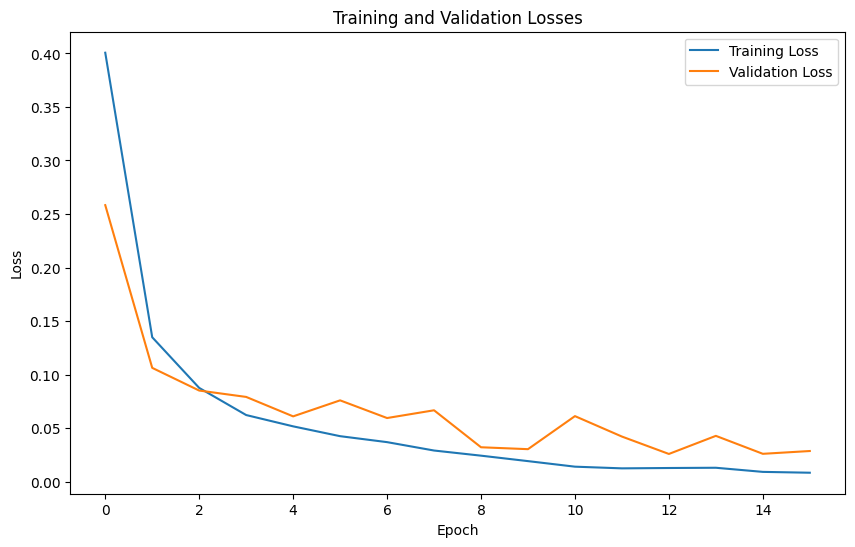

In [13]:
#Train

best_val_loss = float('inf')
best_val_acc = 0
counter = 0
early_stop_threshold = 3
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    print("Epoch " + str(epoch+1) + " of " + str(epochs))
    epoch_losses = []
    model.train()
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, leave=False)
    for inputs, targets in progress_bar:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # print(outputs.shape, targets.shape)
        loss = loss_fn(outputs, targets.squeeze())
        epoch_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets.squeeze()).sum().item()
        
        # Update progress bar
        avg_loss = sum(epoch_losses)/len(epoch_losses)
        train_acc = 100 * correct / total
        progress_bar.set_postfix(
            train_loss=f'{avg_loss:.4f}',
            train_acc=f'{train_acc:.2f}%'
        )
    
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model.eval()
    val_epoch_losses = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss = loss_fn(outputs, targets.squeeze())
            val_epoch_losses.append(val_loss.item())
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets.squeeze()).sum().item()
    
    avg_val_loss = sum(val_epoch_losses)/len(val_epoch_losses)
    val_acc = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch + 1}: "
          f"Train Loss = {avg_loss:.4f}, Train Acc = {train_acc:.2f}%, "
          f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.2f}%")
    
    # Early stopping check (now using both loss and accuracy)
    if avg_val_loss < best_val_loss and val_acc >= best_val_acc:
        best_val_loss = avg_val_loss
        best_val_acc = val_acc
        counter = 0

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_loss,
            'val_loss': avg_val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
        }, f'models/{model_name}/best_model.pth')
    else:
        counter += 1
        if counter >= early_stop_threshold:
            print(f'Early stopping triggered after epoch {epoch + 1}')
            break

print("Training finished.")


# Plot training and validation losses
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [40]:
# eval

test_dataset = PathMNIST(split='test', size=224, transform=data_transform, download=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


def test(data_loader):
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            targets = targets.squeeze()
            outputs = model(inputs)
            _, predictions = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predictions == targets).sum().item()

    return 100 * correct / total

print(f"Test accuracy: {test(test_loader):.2f}")



Using downloaded and verified file: C:\Users\marga\.medmnist\pathmnist_224.npz
Test accuracy: 90.53
